<a href="https://colab.research.google.com/github/AMIRMOHAMMAD-OSS/Bioinformatics/blob/main/BODE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!cd /content/aiupred
!unzip /content/aiupred/aiupred.zip

Archive:  /content/aiupred/aiupred.zip
   creating: data/
  inflating: data/decoder.pt         
  inflating: data/embedding.pt       
   creating: __pycache__/
  inflating: __pycache__/aiupred_lib.cpython-311.pyc  
  inflating: __pycache__/aiupred_lib.cpython-310.pyc  
  inflating: aiupred.py              
  inflating: aiupred_lib.py          
  inflating: readme.md               
  inflating: requirements.txt        
  inflating: test.fasta              


In [ ]:
!pip install Bio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 321.1/321.1 kB 21.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 88.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.7/46.7 kB 4.8 MB/s eta 0:00:00


In [ ]:
import json
from pathlib import Path
from typing import List, Dict, Any, Optional, Tuple

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
import aiupred_lib


def calculate_sequence_charge(sequence: str) -> np.ndarray:
    """Compute per-residue charges with N-term and C-term contributions."""
    sequence = sequence.upper()
    definite_charges = {"D": -1, "E": -1, "K": 1, "R": 1, "N_term": 1, "C_term": -1}
    charges = []
    for i, aa in enumerate(sequence):
        charge = definite_charges.get(aa, 0)
        if i == 0:
            charge += definite_charges["N_term"]
        elif i == len(sequence) - 1:
            charge += definite_charges["C_term"]
        charges.append(charge)
    return np.array(charges, dtype=float)


def aromatic_clustering(seq: str) -> float:
    """Quantify clustering of aromatic residues (Y, W, F)."""
    aromatic_res = {"Y", "W", "F"}
    ds = [i for i, res in enumerate(seq) if res in aromatic_res]
    n = len(ds)
    if n <= 1:
        return 0.0
    # average inverse distance across all pairs
    clustering = sum(1 / abs(ds[j] - ds[i]) for i in range(n) for j in range(i + 1, n))
    return clustering / (n * (n - 1) / 2)


def PPII_propensity(seq: str) -> np.ndarray:
    """Compute polyproline II helix propensities per residue."""
    PII = {
        "I": 0.39, "V": 0.39, "L": 0.24, "F": 0.17, "C": 0.25, "M": 0.36, "A": 0.37, "G": 0.13,
        "T": 0.32, "S": 0.24, "W": 0.25, "Y": 0.25, "P": 1.00, "H": 0.20, "E": 0.42, "Q": 0.53,
        "D": 0.30, "N": 0.27, "K": 0.56, "R": 0.38
    }
    return np.array([PII.get(res, 0.0) for res in seq], dtype=float)


def compute_handcrafted_features(
    sequence: str,
    region_type: str,
    embedding_model=None,
    regression_model=None,
    device: str = "cpu",
    dim: int = 15,
) -> np.ndarray:
    """Compute handcrafted features depending on NRPS region type."""
    seq = str(sequence)
    features: List[float]

    if region_type in ["A-T", "T-C"]:  # Linkers
        if len(seq) >= 5:
            iupred_scores = aiupred_lib.predict_disorder(seq, embedding_model, regression_model, device)
            mean_iupred = float(np.mean(iupred_scores)) if len(iupred_scores) > 0 else 0.0
        else:
            mean_iupred = 0.0
        charges = calculate_sequence_charge(seq)
        features = [
            len(seq),
            float(np.mean(charges)),
            mean_iupred,
            aromatic_clustering(seq),
            float(np.mean(PPII_propensity(seq))),
        ]

    elif region_type == "A":  # Simplified Stachelhaus code (hydrophobicity at first 10 positions)
        features = [1 if i < len(seq) and seq[i] in "AILV" else 0 for i in range(10)]

    elif region_type == "T":  # Serine motif
        features = [1 if "S" in seq else 0]

    elif region_type == "C":  # HH motif + charge
        charges = calculate_sequence_charge(seq)
        features = [1 if "HH" in seq else 0, float(np.mean(charges))]

    else:
        features = []

    # Pad or truncate to fixed dimension
    if len(features) < dim:
        features += [0.0] * (dim - len(features))
    else:
        features = features[:dim]

    return np.array(features, dtype=float)


def safe_json_load(x: str) -> Optional[List[Dict[str, Any]]]:
    """Safe JSON parsing with fallback."""
    try:
        return json.loads(x)
    except Exception:
        return None


def parse_excel(
    data_file: str | Path,
    embedding_model=None,
    regression_model=None,
    device: str = "cpu",
    feature_dim: int = 15,
) -> Dict[str, Any]:
    """Parse Excel file of NRPS modules into sequences + handcrafted features."""
    df = pd.read_excel(data_file)

    # Filter: keep rows with exactly one linker region between domains
    df = df[df["Between_T_C_Domains"].apply(lambda x: len(safe_json_load(x) or []) == 1)]
    df = df[df["Between_A_T_Domains"].apply(lambda x: len(safe_json_load(x) or []) == 1)]

    modules, features, labels, bgc_ids = [], [], [], []

    for _, row in tqdm(df.iterrows(), total=len(df), desc="Parsing modules"):
        module_seqs = [
            row["A_Sequence"],
            "",  # A-T linker
            row["T_Sequence"],
            "",  # T-C linker
            row["C_Sequence"],
        ]

        # A-T linker
        linker_info = safe_json_load(row["Between_A_T_Domains"])
        if linker_info:
            module_seqs[1] = linker_info[0].get("Sequence", "")
        else:
            module_seqs[1] = "GS" * 20

        # T-C linker
        linker_info = safe_json_load(row["Between_T_C_Domains"])
        if linker_info:
            module_seqs[3] = linker_info[0].get("Sequence", "")
        else:
            module_seqs[3] = "PP" * 20

        # Store sequences
        modules.append(module_seqs)
        labels.append(1)  # positive label
        bgc_ids.append(row["BGC_ID"])

        # Compute handcrafted features
        region_features = [
            compute_handcrafted_features(seq, reg, embedding_model, regression_model, device, feature_dim)
            for seq, reg in zip(module_seqs, ["A", "A-T", "T", "T-C", "C"])
        ]
        features.append(region_features)

    return {
        "sequences": modules,
        "features": np.array(features, dtype=float),
        "labels": np.array(labels, dtype=int),
        "bgc_ids": np.array(bgc_ids),
    }


if __name__ == "__main__":
    # Initialize IUPred models
    embedding_model, regression_model, device = aiupred_lib.init_models()
    data_file = Path("/content/drive/MyDrive/NRPS-dataet/MiBIG/MiBIG_tridomains_extracted.xlsx")
    data = parse_excel(data_file, embedding_model, regression_model, device)
    print(f"Parsed {len(data['sequences'])} modules")
    print(f"Feature tensor shape: {data['features'].shape}")


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Parsing modules:   0%|          | 0/1821 [00:00<?, ?it/s]

ValueError: If mode is 'interp', window_length must be less than or equal to the size of x.

In [ ]:
import json
from pathlib import Path
from typing import List, Dict, Any, Optional, Tuple

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

import aiupred_lib

import logging

# configure a small logger
logging.basicConfig(level=logging.WARNING)
logger = logging.getLogger("nrps_preproc")

# choose a conservative minimum length to run IUPred safely
MIN_IUPRED_LEN = 11  # adjust if you know aiupred internally uses a different window

def safe_predict_iupred(seq: str, embedding_model=None, regression_model=None, device="cpu"):
    """
    Safely call aiupred_lib.predict_disorder, returning an array of scores.
    If seq is too short or aiupred errors, return a fallback constant array.
    """
    seq = str(seq or "")
    if len(seq) < MIN_IUPRED_LEN:
        # Short sequences: use small fallback (either zeros or a mild disorder estimate)
        # Using mild default 0.4 is often safer than 0.0; choose what suits you.
        fallback_score = 0.4
        return np.full(len(seq), fallback_score, dtype=float)

    try:
        scores = aiupred_lib.predict_disorder(seq, embedding_model, regression_model, device)
        scores = np.array(scores, dtype=float)
        # If for any reason returned empty or wrong shape, fallback
        if scores.size == 0:
            raise ValueError("Empty iupred output")
        return scores
    except Exception as e:
        # Catch ValueError from savgol and any other issues
        logger.warning(f"IUPred failed for seq len={len(seq)}; using fallback. Error: {e}")
        fallback_score = 0.4
        return np.full(len(seq), fallback_score, dtype=float)


def compute_handcrafted_features(
    sequence: str,
    region_type: str,
    embedding_model=None,
    regression_model=None,
    device: str = "cpu",
    dim: int = 15,
) -> np.ndarray:
    """Compute handcrafted features depending on NRPS region type. Uses safe IUPred wrapper."""
    seq = str(sequence or "")
    features: list[float]

    if region_type in ["A-T", "T-C"]:  # Linkers
        # Use safe predictor
        iupred_scores = safe_predict_iupred(seq, embedding_model, regression_model, device)
        mean_iupred = float(np.mean(iupred_scores)) if iupred_scores.size > 0 else 0.0

        charges = calculate_sequence_charge(seq)
        mean_charge = float(np.mean(charges)) if charges.size > 0 else 0.0
        pp2 = np.mean(PPII_propensity(seq)) if len(seq) > 0 else 0.0

        features = [
            len(seq),
            mean_charge,
            mean_iupred,
            aromatic_clustering(seq),
            float(pp2),
        ]

    elif region_type == "A":
        # Expand Stachelhaus idea but keep compact: one-hot hydrophobic first-10 + count of motif
        stachel = [1.0 if i < len(seq) and seq[i] in "AILV" else 0.0 for i in range(10)]
        features = stachel

    elif region_type == "T":
        # Find exact conserved serine position or presence within motif window (more informative)
        # Example: check for 'S' in the canonical PCP active site (approx positions vary, so we use presence)
        features = [1.0 if "S" in seq else 0.0]

    elif region_type == "C":
        charges = calculate_sequence_charge(seq)
        mean_charge = float(np.mean(charges)) if charges.size > 0 else 0.0
        features = [1.0 if "HH" in seq else 0.0, mean_charge]

    else:
        features = []

    # Pad/truncate to fixed length
    if len(features) < dim:
        features += [0.0] * (dim - len(features))
    else:
        features = features[:dim]

    return np.array(features, dtype=float)


if __name__ == "__main__":
    # Initialize IUPred models
    embedding_model, regression_model, device = aiupred_lib.init_models()
    data_file = Path("/content/drive/MyDrive/NRPS-dataet/MiBIG/MiBIG_tridomains_extracted.xlsx")
    data = parse_excel(data_file, embedding_model, regression_model, device)
    print(f"Parsed {len(data['sequences'])} modules")
    print(f"Feature tensor shape: {data['features'].shape}")


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


Parsing modules:   0%|          | 0/1821 [00:00<?, ?it/s]

Parsed 1821 modules
Feature tensor shape: (1821, 5, 15)


In [ ]:
data["features"]

array([[[ 0.00000000e+00,  0.00000000e+00,  1.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 4.07000000e+02, -5.89680590e-02,  1.69651045e-01, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 3.50000000e+01, -2.85714286e-02,  8.61843761e-01, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 1.00000000e+00, -3.67892977e-02,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00]],

       [[ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 1.07000000e+02, -2.80373832e-02,  3.18010492e-01, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
        [ 1.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
          0.00000000e+00,  0.00000000e+00,  0.00000

In [ ]:
from transformers import AutoTokenizer, AutoModel



In [ ]:
"""
NRPS parser with ESM2-t33 (650M) + attention pooling + (optional) motif pooling
- Produces fixed-size per-region vectors: [handcrafted_dim + esm_dim(+esm_dim if motif_cat)]
- Returns features with shape (N_modules, 5, D_total) and an optional mask (N, 5)
- Includes safe IUPred wrapper and robust JSON/linker handling

Tested in Colab with transformers ESM2 and large model download.
"""
from __future__ import annotations

import json
from pathlib import Path
from typing import List, Dict, Any, Optional, Tuple

import logging
import numpy as np
import pandas as pd
from tqdm import tqdm

import torch
import torch.nn as nn
from transformers import EsmModel, EsmTokenizer

# ----------------------------
# Logging
# ----------------------------
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger("nrps_parser")

# ----------------------------
# IUPred & handcrafted features utilities
# ----------------------------
import aiupred_lib

MIN_IUPRED_LEN = 11  # conservative minimum to avoid savgol issues


def safe_json_load(x: Any) -> Optional[Any]:
    try:
        if pd.isna(x):
            return None
        return json.loads(x)
    except Exception:
        return None


def calculate_sequence_charge(sequence: str) -> np.ndarray:
    sequence = (sequence or "").upper()
    definite = {"D": -1, "E": -1, "K": 1, "R": 1, "N_term": 1, "C_term": -1}
    out = []
    for i, aa in enumerate(sequence):
        c = definite.get(aa, 0)
        if i == 0:
            c += definite["N_term"]
        elif i == len(sequence) - 1:
            c += definite["C_term"]
        out.append(c)
    return np.asarray(out, dtype=float)


def aromatic_clustering(seq: str) -> float:
    arom = {"Y", "W", "F"}
    idxs = [i for i, aa in enumerate(seq or "") if aa in arom]
    n = len(idxs)
    if n <= 1:
        return 0.0
    s = 0.0
    pairs = 0
    for i in range(n - 1):
        for j in range(i + 1, n):
            d = abs(idxs[j] - idxs[i])
            if d > 0:
                s += 1.0 / d
                pairs += 1
    return float(s / max(pairs, 1))


def PPII_propensity(seq: str) -> List[float]:
    table = {
        'I': 0.39, 'V': 0.39, 'L': 0.24, 'F': 0.17, 'C': 0.25, 'M': 0.36, 'A': 0.37, 'G': 0.13,
        'T': 0.32, 'S': 0.24, 'W': 0.25, 'Y': 0.25, 'P': 1.00, 'H': 0.20, 'E': 0.42, 'Q': 0.53,
        'D': 0.30, 'N': 0.27, 'K': 0.56, 'R': 0.38
    }
    return [table.get(a, 0.0) for a in (seq or "")]


def safe_predict_iupred(seq: str, embedding_model=None, regression_model=None, device: str = "cpu") -> np.ndarray:
    seq = str(seq or "")
    if len(seq) < MIN_IUPRED_LEN:
        return np.full(len(seq), 0.4, dtype=float)
    try:
        scores = aiupred_lib.predict_disorder(seq, embedding_model, regression_model, device)
        scores = np.asarray(scores, dtype=float)
        if scores.size == 0:
            raise ValueError("empty iupred output")
        return scores
    except Exception as e:
        logger.warning(f"IUPred failed (len={len(seq)}): {e}. Using fallback 0.4.")
        return np.full(len(seq), 0.4, dtype=float)


def compute_handcrafted_features(
    sequence: str,
    region_type: str,
    embedding_model=None,
    regression_model=None,
    device: str = "cpu",
    dim: int = 15,
) -> np.ndarray:
    seq = str(sequence or "")
    feats: List[float]

    if region_type in ["A-T", "T-C"]:  # linkers
        ius = safe_predict_iupred(seq, embedding_model, regression_model, device)
        mean_iupred = float(ius.mean()) if ius.size else 0.0
        charges = calculate_sequence_charge(seq)
        mean_charge = float(charges.mean()) if charges.size else 0.0
        pp2 = float(np.mean(PPII_propensity(seq))) if seq else 0.0
        feats = [len(seq), mean_charge, mean_iupred, aromatic_clustering(seq), pp2]

    elif region_type == "A":
        # compact Stachelhaus-like one-hot for first 10 positions being hydrophobic
        feats = [1.0 if i < len(seq) and seq[i] in "AILV" else 0.0 for i in range(10)]

    elif region_type == "T":
        feats = [1.0 if "S" in seq else 0.0]

    elif region_type == "C":
        charges = calculate_sequence_charge(seq)
        mean_charge = float(charges.mean()) if charges.size else 0.0
        feats = [1.0 if "HH" in seq else 0.0, mean_charge]

    else:
        feats = []

    if len(feats) < dim:
        feats += [0.0] * (dim - len(feats))
    else:
        feats = feats[:dim]

    return np.asarray(feats, dtype=float)

# ----------------------------
# ESM2 (t33) and pooling
# ----------------------------
ESM2_MODEL_NAME = "facebook/esm2_t33_650M_UR50D"
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

tokenizer = EsmTokenizer.from_pretrained(ESM2_MODEL_NAME)
esm_model = EsmModel.from_pretrained(ESM2_MODEL_NAME).eval().to(DEVICE)
HIDDEN = esm_model.config.hidden_size  # 1280 for t33


class AttentionPooling(nn.Module):
    def __init__(self, dim: int):
        super().__init__()
        self.attn = nn.Linear(dim, 1)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: (L, d)
        scores = self.attn(x).squeeze(-1)          # (L,)
        weights = torch.softmax(scores, dim=0)     # (L,)
        pooled = torch.sum(weights.unsqueeze(-1) * x, dim=0)
        return pooled  # (d,)


attn_pool = AttentionPooling(HIDDEN).to(DEVICE)

# Optional motif coordinates per region (within-region indices). Keep placeholders or empty.
MOTIF_POS: Dict[str, List[int]] = {
    "A": [],  # e.g., [235, 239, 278]
    "T": [],  # e.g., [7]
    "C": [],  # e.g., [120, 121]
}


@torch.no_grad()
def esm2_pool(seq: str) -> torch.Tensor:
    """Return a fixed (HIDDEN,) ESM2 vector for a sequence via attention pooling.
       Falls back to zeros for empty sequences.
    """
    if not seq or not seq.strip():
        return torch.zeros(HIDDEN, device=DEVICE)

    toks = tokenizer(seq, return_tensors="pt", add_special_tokens=True)
    toks = {k: v.to(DEVICE) for k, v in toks.items()}
    out = esm_model(**toks)
    tok = out.last_hidden_state.squeeze(0)  # (L, d)
    if tok.size(0) >= 2:
        tok = tok[1:-1]  # drop CLS/EOS
    pooled = attn_pool(tok)  # (d,)
    return pooled


@torch.no_grad()
def motif_pool(emb: torch.Tensor, motif_positions: List[int]) -> torch.Tensor:
    """Average embeddings at motif_positions from per-token embeddings if available.
       Here we recompute tokens to get per-token embeddings, then pool motifs.
       If no motifs or OOB, returns zeros(HIDDEN).
    """
    if motif_positions is None or len(motif_positions) == 0:
        return torch.zeros(HIDDEN, device=DEVICE)
    # emb here is already pooled; in this streamlined version we skip motif re-encoding
    # To keep a fixed size and avoid a second forward, return zeros unless you modify to pass token-level emb.
    return torch.zeros(HIDDEN, device=DEVICE)


@torch.no_grad()
def region_vector(
    seq: str,
    handcrafted: np.ndarray,
    region_name: str,
    concat_motif: bool = False,
) -> np.ndarray:
    """Build a fixed-size vector per region: [handcrafted | esm_attn (| motif_emb)]."""
    hf = torch.as_tensor(handcrafted, dtype=torch.float32, device=DEVICE)
    esm_vec = esm2_pool(seq)  # (HIDDEN,)

    if concat_motif:
        motif_vec = motif_pool(esm_vec, MOTIF_POS.get(region_name, []))  # zeros for now
        full = torch.cat([hf, esm_vec, motif_vec], dim=-1)
    else:
        full = torch.cat([hf, esm_vec], dim=-1)

    return full.detach().cpu().numpy()


# ----------------------------
# Main parser that returns fixed-dim tensors
# ----------------------------
def parse_excel(
    data_file: str | Path,
    embedding_model=None,
    regression_model=None,
    device_iupred: str = "cpu",
    feature_dim: int = 15,
    concat_motif: bool = False,
) -> Dict[str, Any]:
    df = pd.read_excel(data_file)

    # Keep rows with exactly one linker region between domains
    df = df[df["Between_T_C_Domains"].apply(lambda x: len(safe_json_load(x) or []) == 1)]
    df = df[df["Between_A_T_Domains"].apply(lambda x: len(safe_json_load(x) or []) == 1)].iloc[:50]

    modules: List[List[str]] = []
    features_list: List[np.ndarray] = []
    mask_list: List[np.ndarray] = []
    labels: List[int] = []
    bgc_ids: List[Any] = []

    regions = ["A", "A-T", "T", "T-C", "C"]

    for _, row in tqdm(df.iterrows(), total=len(df), desc="Parsing modules"):
        module_seqs = [
            row["A_Sequence"],
            "",  # A-T linker
            row["T_Sequence"],
            "",  # T-C linker
            row["C_Sequence"],
        ]

        # A-T linker
        at_info = safe_json_load(row["Between_A_T_Domains"])
        module_seqs[1] = (at_info[0].get("Sequence", "") if at_info else "GS" * 20)

        # T-C linker
        tc_info = safe_json_load(row["Between_T_C_Domains"])
        module_seqs[3] = (tc_info[0].get("Sequence", "") if tc_info else "PP" * 20)

        modules.append(module_seqs)
        labels.append(1)
        bgc_ids.append(row.get("BGC_ID", None))

        # Per-region vectors
        region_vecs: List[np.ndarray] = []
        region_mask: List[float] = []
        for seq, reg in zip(module_seqs, regions):
            handcrafted = compute_handcrafted_features(seq, reg, embedding_model, regression_model, device_iupred, feature_dim)
            vec = region_vector(seq, handcrafted, reg, concat_motif=concat_motif)
            region_vecs.append(vec)
            # mask = 0 if both handcrafted and esm are zeros (rare), else 1
            region_mask.append(0.0 if np.allclose(vec, 0.0) else 1.0)

        # Ensure fixed shape per module
        region_mat = np.stack(region_vecs, axis=0)     # (5, D_total)
        features_list.append(region_mat)
        mask_list.append(np.asarray(region_mask, dtype=float))

    features = np.stack(features_list, axis=0)  # (N, 5, D_total)
    mask = np.stack(mask_list, axis=0)         # (N, 5)

    return {
        "sequences": modules,
        "features": features,
        "mask": mask,
        "labels": np.asarray(labels, dtype=int),
        "bgc_ids": np.asarray(bgc_ids),
        "d_in": features.shape[-1],
    }


# ----------------------------
# Example run
# ----------------------------
if __name__ == "__main__":
    # Initialize IUPred models (if you actually use IUPred)
    emb_model, reg_model, iupred_device = aiupred_lib.init_models()

    data_file = Path("/content/drive/MyDrive/NRPS-dataet/MiBIG/MiBIG_tridomains_extracted.xlsx")
    data = parse_excel(
        data_file,
        embedding_model=emb_model,
        regression_model=reg_model,
        device_iupred=iupred_device,
        feature_dim=15,
        concat_motif=False,  # set True if you implement real motif pooling
    )

    print(f"Parsed {len(data['sequences'])} modules")
    print(f"Feature tensor shape: {data['features'].shape}")
    print(f"Mask shape: {data['mask'].shape}")
    print(f"Per-region dim (d_in): {data['d_in']}")


Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t33_650M_UR50D and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(
Parsing modules: 100%|██████████| 50/50 [00:30<00:00,  1.65it/s]

Parsed 50 modules
Feature tensor shape: (50, 5, 1295)
Mask shape: (50, 5)
Per-region dim (d_in): 1295


In [ ]:
data["features"][0][0]

array([ 0.        ,  0.        ,  1.        , ..., -0.18117264,
       -0.00586262,  0.04546448], dtype=float32)

Epoch 1/300, Train Loss: 3554.3462
Epoch 1/300, Test Loss: 4275.4556
Epoch 2/300, Train Loss: 3553.2820
Epoch 2/300, Test Loss: 4273.7339
Epoch 3/300, Train Loss: 3552.5300
Epoch 3/300, Test Loss: 4273.1836
Epoch 4/300, Train Loss: 3551.7649
Epoch 4/300, Test Loss: 4272.8271
Epoch 5/300, Train Loss: 3551.0925
Epoch 5/300, Test Loss: 4271.3193
Epoch 6/300, Train Loss: 3550.2527
Epoch 6/300, Test Loss: 4269.1304
Epoch 7/300, Train Loss: 3549.0496
Epoch 7/300, Test Loss: 4269.1270
Epoch 8/300, Train Loss: 3548.0181
Epoch 8/300, Test Loss: 4266.2178
Epoch 9/300, Train Loss: 3547.3157
Epoch 9/300, Test Loss: 4265.9355
Epoch 10/300, Train Loss: 3546.5483
Epoch 10/300, Test Loss: 4263.8633
Epoch 11/300, Train Loss: 3545.0991
Epoch 11/300, Test Loss: 4261.5913
Epoch 12/300, Train Loss: 3543.3635
Epoch 12/300, Test Loss: 4260.4404
Epoch 13/300, Train Loss: 3542.5161
Epoch 13/300, Test Loss: 4259.8701
Epoch 14/300, Train Loss: 3540.5889
Epoch 14/300, Test Loss: 4255.3320
Epoch 15/300, Train Loss

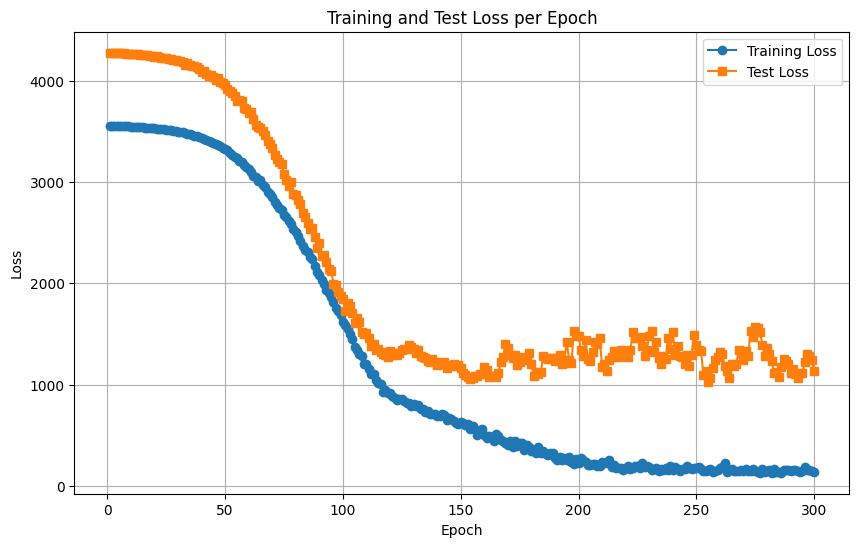

Done. Last train loss: 134.6669158935547
Loss plot saved as 'loss_plot.png'


In [ ]:
from __future__ import annotations

import math
import os
from dataclasses import dataclass
from typing import Optional, Dict, Any, Tuple

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

# ----------------------------
# Config
# ----------------------------
@dataclass
class VAEConfig:
    d_in: int                 # input dim per region (handcrafted + esm)
    n_regions: int = 5        # A, A-T, T, T-C, C
    d_model: int = 256        # token/region embedding dim inside encoder
    n_heads: int = 8
    n_layers: int = 2
    d_ff: int = 512
    dropout: float = 0.1

    latent_dim: int = 64
    beta: float = 1.0         # KL weight
    kl_warmup_steps: int = 2000

    decoder_hidden: int = 256
    per_region_decoders: bool = False  # if True, a small head per region

    lr: float = 1e-3
    weight_decay: float = 1e-4
    batch_size: int = 64
    num_epochs: int = 30

    # optional supervised probe to encourage z to correlate with functionality
    use_probe: bool = False
    probe_weight: float = 0.1

    device: str = "cuda" if torch.cuda.is_available() else "cpu"

# ----------------------------
# Dataset
# ----------------------------
class NRPSDataset(Dataset):
    def __init__(self, features: np.ndarray, mask: Optional[np.ndarray] = None):
        """
        features: (N, 5, D)
        mask: (N, 5) 1=present, 0=missing (optional). If None, assume all ones.
        """
        assert features.ndim == 3
        self.x = torch.from_numpy(features).float()
        if mask is None:
            self.m = torch.ones(self.x.shape[:2], dtype=torch.float32)
        else:
            self.m = torch.from_numpy(mask).float()

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self, idx):
        return self.x[idx], self.m[idx]

# ----------------------------
# Positional & Segment Embeddings (5 tokens)
# ----------------------------
class SegmentPositionalEmbedding(nn.Module):
    def __init__(self, n_regions: int, d_model: int):
        super().__init__()
        self.proj = nn.Linear(1, d_model)  # not used, kept for extensibility
        self.segment = nn.Embedding(n_regions, d_model)
        self.pos = nn.Embedding(n_regions, d_model)  # positions 0..n_regions-1

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        # x: (B, R, D_in) -> we will project elsewhere; here we just need segment+pos
        B, R, _ = x.shape
        seg_ids = torch.arange(R, device=x.device).unsqueeze(0).expand(B, R)
        pos_ids = torch.arange(R, device=x.device).unsqueeze(0).expand(B, R)
        return self.segment(seg_ids) + self.pos(pos_ids)

# ----------------------------
# Encoder
# ----------------------------
class MultiRegionEncoder(nn.Module):
    def __init__(self, cfg: VAEConfig):
        super().__init__()
        self.cfg = cfg
        self.input_proj = nn.Linear(cfg.d_in, cfg.d_model)
        enc_layer = nn.TransformerEncoderLayer(
            d_model=cfg.d_model,
            nhead=cfg.n_heads,
            dim_feedforward=cfg.d_ff,
            dropout=cfg.dropout,
            batch_first=True,
            activation="gelu",
        )
        self.encoder = nn.TransformerEncoder(enc_layer, num_layers=cfg.n_layers)
        self.segpos = SegmentPositionalEmbedding(cfg.n_regions, cfg.d_model)
        self.layernorm = nn.LayerNorm(cfg.d_model)
        # take [CLS]-like pooled token via mean over regions or first token? we'll add a CLS param
        self.cls_token = nn.Parameter(torch.randn(1, 1, cfg.d_model) * 0.02)
        self.to_mu = nn.Linear(cfg.d_model, cfg.latent_dim)
        self.to_logvar = nn.Linear(cfg.d_model, cfg.latent_dim)

    def forward(self, x: torch.Tensor, mask: Optional[torch.Tensor] = None) -> Tuple[torch.Tensor, torch.Tensor, torch.Tensor]:
        # x: (B, R, D_in), mask: (B, R)
        B, R, _ = x.shape
        h = self.input_proj(x)  # (B, R, d_model)
        h = h + self.segpos(x)  # add segment+pos embeddings
        # prepend CLS token
        cls = self.cls_token.expand(B, 1, -1)
        h = torch.cat([cls, h], dim=1)  # (B, 1+R, d_model)

        # build attn mask: allow all tokens; padding mask for regions if provided
        src_key_padding_mask = None
        if mask is not None:
            # mask True means to ignore; here we create padding for missing regions
            pad = (mask <= 0).bool()
            pad = torch.cat([torch.zeros(B, 1, device=pad.device, dtype=torch.bool), pad], dim=1)
            src_key_padding_mask = pad  # (B, 1+R)

        h = self.encoder(h, src_key_padding_mask=src_key_padding_mask)
        h_cls = self.layernorm(h[:, 0])  # (B, d_model)
        mu = self.to_mu(h_cls)
        logvar = self.to_logvar(h_cls)
        return mu, logvar, h[:, 1:]  # return per-region encoded tokens too if needed

# ----------------------------
# Decoder
# ----------------------------
class MultiRegionDecoder(nn.Module):
    def __init__(self, cfg: VAEConfig):
        super().__init__()
        self.cfg = cfg
        self.from_z = nn.Sequential(
            nn.Linear(cfg.latent_dim, cfg.decoder_hidden),
            nn.GELU(),
            nn.Linear(cfg.decoder_hidden, cfg.n_regions * cfg.d_model),
            nn.GELU(),
        )
        # map region hidden back to input space
        if cfg.per_region_decoders:
            self.decoders = nn.ModuleList(
                [nn.Sequential(
                    nn.Linear(cfg.d_model, cfg.decoder_hidden),
                    nn.GELU(),
                    nn.Linear(cfg.decoder_hidden, cfg.d_in)
                ) for _ in range(self.cfg.n_regions)]
            )
        else:
            self.shared = nn.Sequential(
                nn.Linear(cfg.d_model, cfg.decoder_hidden),
                nn.GELU(),
                nn.Linear(cfg.decoder_hidden, cfg.d_in)
            )

    def forward(self, z: torch.Tensor) -> torch.Tensor:
        B = z.size(0)
        H = self.from_z(z)  # (B, R*d_model)
        H = H.view(B, self.cfg.n_regions, self.cfg.d_model)
        if self.cfg.per_region_decoders:
            outs = []
            for r in range(self.cfg.n_regions):
                outs.append(self.decoders[r](H[:, r, :]))
            x_hat = torch.stack(outs, dim=1)
        else:
            x_hat = self.shared(H.view(-1, self.cfg.d_model))
            x_hat = x_hat.view(B, self.cfg.n_regions, self.cfg.d_in)
        return x_hat

# ----------------------------
# VAE Wrapper
# ----------------------------
class MultiInputVAE(nn.Module):
    def __init__(self, cfg: VAEConfig):
        super().__init__()
        self.cfg = cfg
        self.encoder = MultiRegionEncoder(cfg)
        self.decoder = MultiRegionDecoder(cfg)
        if cfg.use_probe:
            self.probe = nn.Sequential(
                nn.Linear(cfg.latent_dim, 64), nn.GELU(), nn.Linear(64, 1)
            )
        else:
            self.probe = None

    def reparameterize(self, mu: torch.Tensor, logvar: torch.Tensor) -> torch.Tensor:
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x: torch.Tensor, mask: Optional[torch.Tensor] = None) -> Dict[str, torch.Tensor]:
        mu, logvar, _ = self.encoder(x, mask)
        z = self.reparameterize(mu, logvar)
        x_hat = self.decoder(z)
        out = {"x_hat": x_hat, "mu": mu, "logvar": logvar, "z": z}
        if self.probe is not None:
            out["probe"] = self.probe(z).squeeze(-1)
        return out

# ----------------------------
# Loss
# ----------------------------
class ELBOLoss(nn.Module):
    def __init__(self, cfg: VAEConfig):
        super().__init__()
        self.cfg = cfg

    def forward(self, x: torch.Tensor, out: Dict[str, torch.Tensor], mask: Optional[torch.Tensor] = None,
                step: int = 0, y: Optional[torch.Tensor] = None) -> Tuple[torch.Tensor, Dict[str, float]]:
        x_hat, mu, logvar = out["x_hat"], out["mu"], out["logvar"]
        # Reconstruction loss with optional region mask
        if mask is not None:
            # expand mask to feature dim
            m = mask.unsqueeze(-1)  # (B, R, 1)
            recon = F.mse_loss(x_hat * m, x * m, reduction="sum") / (m.sum() + 1e-8)
        else:
            recon = F.mse_loss(x_hat, x, reduction="mean")
        # KL
        kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp(), dim=1).mean()
        # Warmup schedule
        beta = min(1.0, self.cfg.beta * (step / max(1, self.cfg.kl_warmup_steps)))
        loss = recon + beta * kl
        logs = {"loss": float(loss.item()), "recon": float(recon.item()), "kl": float(kl.item()), "beta": float(beta)}
        # Optional probe
        if (y is not None) and ("probe" in out):
            bce = F.binary_cross_entropy_with_logits(out["probe"], y.float())
            loss = loss + self.cfg.probe_weight * bce
            logs["probe_bce"] = float(bce.item())
        return loss, logs

# ----------------------------
# Training loop with optional early stopping
# ----------------------------
def train_vae(cfg: VAEConfig, train_set: NRPSDataset, test_set: Optional[NRPSDataset] = None,
              y_train: Optional[torch.Tensor] = None, y_test: Optional[torch.Tensor] = None,
              ckpt_path: Optional[str] = None, use_early_stopping: bool = True) -> Tuple[MultiInputVAE, Dict[str, Any]]:
    model = MultiInputVAE(cfg).to(cfg.device)
    opt = torch.optim.AdamW(model.parameters(), lr=cfg.lr, weight_decay=cfg.weight_decay)
    crit = ELBOLoss(cfg)

    dl_train = DataLoader(train_set, batch_size=cfg.batch_size, shuffle=True, drop_last=False)
    dl_test = DataLoader(test_set, batch_size=cfg.batch_size, shuffle=False) if test_set is not None else None

    history = {"train": [], "test": []}
    step = 0
    train_losses_per_epoch = []
    test_losses_per_epoch = []
    best_test = math.inf
    patience = 5  # Number of epochs to wait for improvement
    trigger_times = 0

    for epoch in range(cfg.num_epochs):
        model.train()
        train_losses = []
        for i, (xb, mb) in enumerate(dl_train):
            xb = xb.to(cfg.device)
            mb = mb.to(cfg.device)
            yb = None
            if y_train is not None:
                yb = y_train[i * cfg.batch_size: i * cfg.batch_size + xb.size(0)].to(cfg.device)

            opt.zero_grad(set_to_none=True)
            out = model(xb, mb)
            loss, logs = crit(xb, out, mb, step=step, y=yb)
            train_losses.append(logs["loss"])
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()

            history["train"].append({"epoch": epoch, "step": step, **logs})
            step += 1

        # Compute and print average training loss for the epoch
        train_mean_loss = float(np.mean(train_losses))
        train_losses_per_epoch.append(train_mean_loss)
        print(f"Epoch {epoch + 1}/{cfg.num_epochs}, Train Loss: {train_mean_loss:.4f}")

        # Test evaluation after each epoch
        if dl_test is not None:
            model.eval()
            test_losses = []
            with torch.no_grad():
                for j, (xb, mb) in enumerate(dl_test):
                    xb = xb.to(cfg.device)
                    mb = mb.to(cfg.device)
                    yb = None
                    if y_test is not None:
                        yb = y_test[j * cfg.batch_size: j * cfg.batch_size + xb.size(0)].to(cfg.device)
                    out = model(xb, mb)
                    loss, logs = crit(xb, out, mb, step=step, y=yb)
                    test_losses.append(logs["loss"])
                    history["test"].append({"epoch": epoch, "step": step, **logs})
                test_mean = float(np.mean(test_losses)) if test_losses else math.inf
                test_losses_per_epoch.append(test_mean)
                print(f"Epoch {epoch + 1}/{cfg.num_epochs}, Test Loss: {test_mean:.4f}")

                # Early stopping and checkpoint
                if use_early_stopping:
                    if test_mean < best_test:
                        best_test = test_mean
                        trigger_times = 0
                        if ckpt_path:
                            os.makedirs(os.path.dirname(ckpt_path), exist_ok=True)
                            torch.save({"model": model.state_dict(), "cfg": cfg.__dict__}, ckpt_path)
                    else:
                        trigger_times += 1
                        if trigger_times >= patience:
                            print(f"Early stopping triggered at epoch {epoch + 1}")
                            break

    # Plot training and test loss
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, len(train_losses_per_epoch) + 1), train_losses_per_epoch, label='Training Loss', marker='o')
    if test_losses_per_epoch:
        plt.plot(range(1, len(test_losses_per_epoch) + 1), test_losses_per_epoch, label='Test Loss', marker='s')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Test Loss per Epoch')
    plt.legend()
    plt.grid(True)
    plt.savefig('loss_plot.png')
    plt.show()
    plt.close()

    return model, history

# ----------------------------
# Utilities
# ----------------------------
def split_train_test(features: np.ndarray, test_frac: float = 0.1, seed: int = 42,
                     mask: Optional[np.ndarray] = None):
    rng = np.random.default_rng(seed)
    N = features.shape[0]
    idx = np.arange(N)
    rng.shuffle(idx)
    n_test = int(N * test_frac)
    test_idx = idx[:n_test]
    train_idx = idx[n_test:]
    x_train = features[train_idx]
    x_test = features[test_idx]
    m_train = mask[train_idx] if mask is not None else None
    m_test = mask[test_idx] if mask is not None else None
    return (x_train, m_train), (x_test, m_test)

# ----------------------------
# Example usage (plug in your parsed data)
# ----------------------------
if __name__ == "__main__":
    # Suppose you already built `data` using the ESM2-enhanced parser
    # data = parse_excel(...)
    # X has shape (N, 5, D_in)
    # Optionally build a mask where a region vector is all-zero (missing) -> 0 else 1
    # Here we mock a small random example to illustrate wiring
    N, R, D = 128, 5, 512
    X = data["features"]
    mask = (np.abs(X).sum(axis=2) > 1e-8).astype(np.float32)

    (xtr, mtr), (xte, mte) = split_train_test(X, test_frac=0.1, seed=17, mask=mask)
    ds_tr = NRPSDataset(xtr, mtr)
    ds_te = NRPSDataset(xte, mte)

    cfg = VAEConfig(
    d_in=1295,  # Match the parsed feature dimension
    n_regions=5,
    d_model=256,
    n_heads=8,
    n_layers=2,
    d_ff=512,
    latent_dim=64,
    beta=10.0,
    kl_warmup_steps=500,
    dropout=0.4,
    decoder_hidden=256,
    per_region_decoders=True,
    lr=1e-4,
    weight_decay=1e-3,
    batch_size=64,
    num_epochs=300,
    use_probe=True,
    probe_weight=0.1
)

    model, hist = train_vae(cfg, ds_tr, ds_te, ckpt_path="./checkpoints/mi_vae.pt", use_early_stopping=False)
    print("Done. Last train loss:", hist["train"][-1]["loss"])
    print("Loss plot saved as 'loss_plot.png'")

In [ ]:
ds_tr.x.shape

torch.Size([116, 5, 512])